# Imports

In [478]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
from PIL import Image
import time


from skimage import color
from skimage.feature import hog

from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog

import cv2
import argparse as ap


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from keras.utils import np_utils

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD


from skimage.feature import hog
from skimage import data, color, exposure
from sklearn import cross_validation



import pyimagesearch.imutils as imutils
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Bring in images

In [284]:
os.listdir("shipsnet_data/shipsnet");
path =r'/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet'
boats = glob.glob(os.path.join(path,'1*.png'))
no_boats = glob.glob(os.path.join(path,'0*.png'))
boats.extend(no_boats)

In [285]:
image_data = []
image_tag = []

def makeImageDataTagArray(files_list):
    positive = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/1.*")
    negative = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/0.*")
    for i in files_list:
        if positive.match(i):
            image_tag.append(1)
        if negative.match(i):
            image_tag.append(0)
        img = Image.open(i)
        arr = np.array(img)
        image_data.append(arr)
        
makeImageDataTagArray(boats)

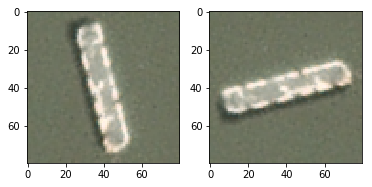

In [286]:
plt.subplot(1,2,1)
plt.imshow(image_data[200])
plt.subplot(1,2,2)
plt.imshow(np.rot90(image_data[200]));

## normalize images

In [287]:
def normalize(img_array):
    image_mean = np.mean(img_array)
    normalized_image = img_array / image_mean
    return normalized_image

In [288]:
norm_images = []
for image_array in image_data:
    norm = normalize(image_array)
    norm_images.append(norm)

In [289]:
norm_images_array = np.asarray(norm_images)

# Run SVM

In [290]:
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return np.array(vectors)

In [389]:
x_vect = make_vector(image_data)
x_norm_vect = make_vector(norm_images_array)
y_vect = np.ravel(image_tag)


In [292]:
xtrain, xtest, ytrain, ytest = train_test_split(x_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)
xnormtrain, xnormtest, ytrain, ytest = train_test_split(x_norm_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)



In [293]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def test_model(model, xtrain, ytrain, xtest, ytest):
    
    start_time = time.time()
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = ytest
    y_pred = clf.predict(xtest)

    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


    cm=confusion_matrix(y_true, y_pred, labels=None)

    plt.figure()
    plot_confusion_matrix(cm)
    return model

    print("--- %s seconds ---" % (time.time() - start_time))
    


In [311]:
xtest

array([[ 79,  79,  69, ...,  53,  58,  47],
       [ 68,  70,  58, ...,  67,  67,  57],
       [189, 160, 136, ..., 160, 143, 125],
       ...,
       [ 84,  93,  80, ...,  72,  87,  73],
       [229, 219, 206, ..., 200, 192, 177],
       [ 60,  76,  64, ...,  62,  76,  63]], dtype=uint8)

Training Data Accuracy: 1.00
Test Data Accuracy:     0.94
[[400  20]
 [ 11 129]]


Precision:              0.97
Recall:                 0.95
Specificity:              0.92
--- 207.83714413642883 seconds ---


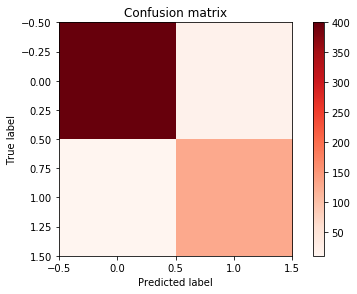

In [294]:
#SVC
svc = SVC(kernel = 'poly',degree = 3, probability=True)
start_time = time.time()
clf = svc.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)

conf = confusion_matrix(y_true, y_pred)

print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))

In [319]:
print(clf.predict(np.asarray(xtest[1:10])))
print(ytest[1:10])

[1 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 1]


In [324]:
obs = np.asarray(xtest[1])
len(obs)
clf.predict(obs.reshape(1, -1))[0]

1

Text(0,0.5,'TPR')

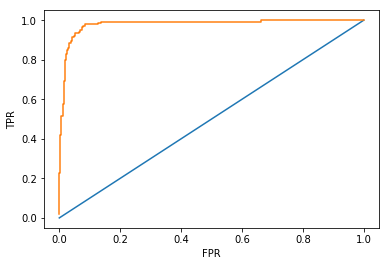

In [295]:
y_score=clf.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

## Tune SVM model

In [273]:
#define hyperparameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': Cs},
                   {'kernel': ['poly'], 'degree':[2,3,4], 'gamma': gammas,
                     'C': Cs}]

In [ ]:
#scikit opt

# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
#                        scoring='%s_macro' % score)
#     clf.fit(xtrain, ytrain)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     with open('gridResults.pkl', 'wb') as picklefile:
#         pickle.dump(clf, picklefile)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = ytest, clf.predict(xtest)
#     print(classification_report(y_true, y_pred))
#     print()

# Bring in CNN model

In [519]:
X = np.asarray(image_data)
y = np.asarray(image_tag)

In [520]:
X.shape

(2800, 80, 80, 3)

In [521]:
X = X/ 255

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1234, stratify = y, shuffle = True)

In [523]:
# output encoding
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [543]:
y_train[10]

array([0., 1.], dtype=float32)

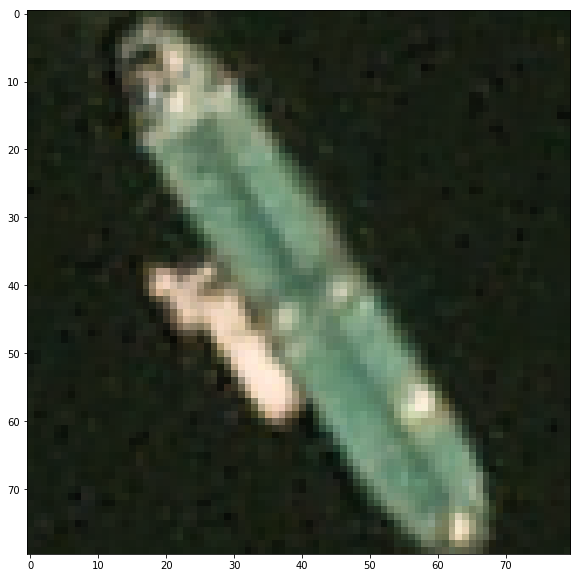

In [542]:
plt.imshow(X_train[10])

## train the network

In [524]:
np.random.seed(42)

In [525]:
# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [526]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 1792 samples, validate on 448 samples
Epoch 1/18
 - 17s - loss: 0.4724 - acc: 0.7902 - val_loss: 0.3096 - val_acc: 0.8862
Epoch 2/18
 - 15s - loss: 0.2871 - acc: 0.8739 - val_loss: 0.2064 - val_acc: 0.9241
Epoch 3/18
 - 16s - loss: 0.2202 - acc: 0.9057 - val_loss: 0.1785 - val_acc: 0.9375
Epoch 4/18
 - 16s - loss: 0.1912 - acc: 0.9157 - val_loss: 0.1416 - val_acc: 0.9464
Epoch 5/18
 - 16s - loss: 0.1622 - acc: 0.9364 - val_loss: 0.1536 - val_acc: 0.9375
Epoch 6/18
 - 15s - loss: 0.1520 - acc: 0.9442 - val_loss: 0.1339 - val_acc: 0.9487
Epoch 7/18
 - 15s - loss: 0.1365 - acc: 0.9470 - val_loss: 0.1296 - val_acc: 0.9576
Epoch 8/18
 - 17s - loss: 0.1260 - acc: 0.9487 - val_loss: 0.2178 - val_acc: 0.9174
Epoch 9/18
 - 15s - loss: 0.1284 - acc: 0.9526 - val_loss: 0.0970 - val_acc: 0.9665
Epoch 10/18
 - 15s - loss: 0.1129 - acc: 0.9548 - val_loss: 0.1280 - val_acc: 0.9576
Epoch 11/18
 - 15s - loss: 0.1052 - acc: 0.9621 - val_loss: 0.1003 - val_acc: 0.9621
Epoch 12/18
 - 15s - loss: 

# Test sliding window with SVM

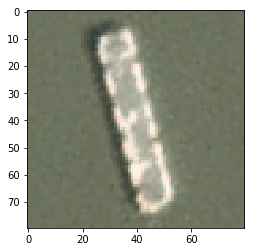

In [298]:
plt.imshow(image_data[200])

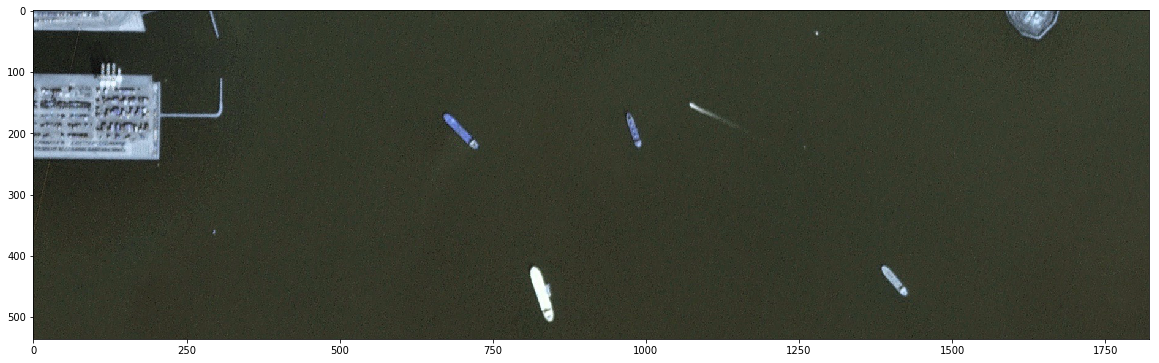

In [357]:
scene = cv2.imread('shipsnet_data/scenes/lb_1_crop.jpg')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(scene)

In [528]:
(winW, winH) = (80, 80)

windows = []
i = 0
for (x, y, window) in sliding_window(scene, stepSize=20, windowSize=(winW, winH)):
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    x_image =np.ravel(window)
    y_pred = clf.predict(x_image.reshape(1, -1))[0]
    if y_pred ==1:
        windows.append(window)
    i+=1

In [529]:
len(windows)

9

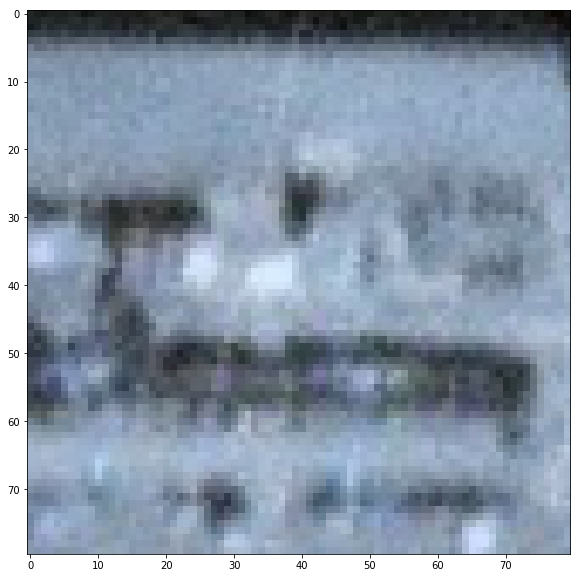

In [531]:
plt.imshow(windows[1])

# Test sliding window with CNN

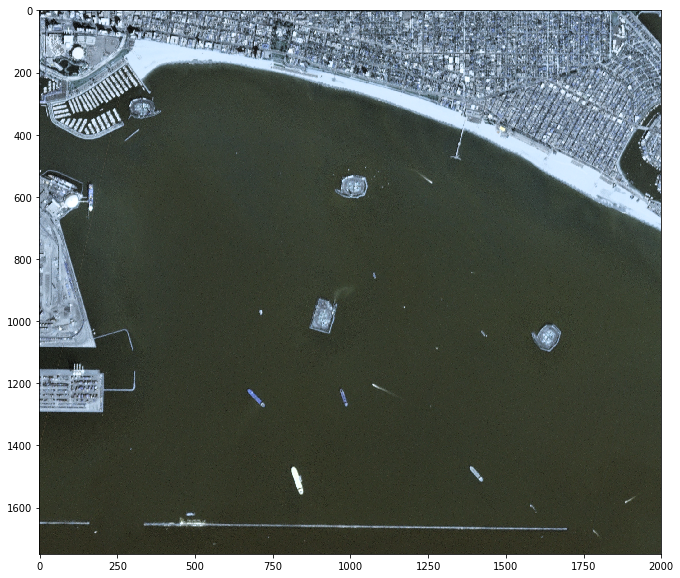

In [614]:
scene = cv2.imread('shipsnet_data/scenes/lb_1.jpg')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(scene)

In [615]:
(winW, winH) = (80, 80)

cnn_windows = []
cnn_coords = []
i = 0
for (x, y, window) in sliding_window(scene, stepSize=12, windowSize=(winW, winH)):
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    cnn_window = np.expand_dims(window, axis=0)
    y_pred = model.predict(cnn_window)
    print(y_pred)
    y_pred_val = list(y_pred[0])[0]
    if y_pred_val == 0.0 :
        print('boat?')
        cnn_coords.append((x,y))
        cnn_windows.append(window)
    i+=1

[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[2.392929e-27 1.000000e+00]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[3.273305e-27 1.000000e+00]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
boat?
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1.

[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1.0000000e+00 6.3808448e-18]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]

[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
boat?
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1.

[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[0. 1.]]
boat?
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1.

[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


In [616]:
i

22540

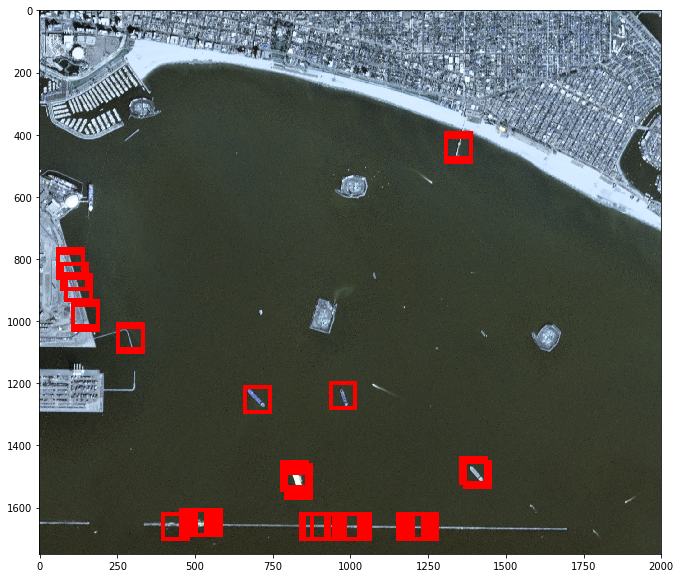

In [618]:
import matplotlib.patches as patches


plt.rcParams["figure.figsize"] = (20,10)

fig,ax = plt.subplots(1)
ax.imshow(scene)

for i in cnn_coords:
    rect = patches.Rectangle(i,80,80,linewidth=4,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()


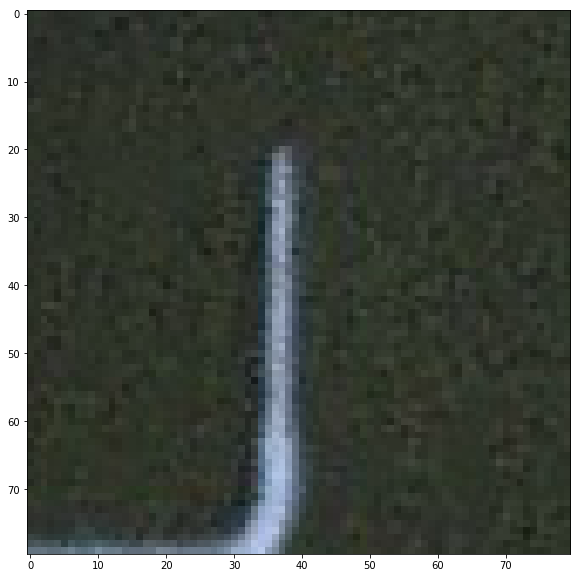

In [592]:
plt.imshow(cnn_windows[0])